# Modelo Predictivo para Identificar Transacciones Fraudulentas en Tarjetas de Crédito

# 🎯 Introducción

El objetivo de este proyecto es **detectar transacciones fraudulentas** en un conjunto de datos de tarjetas de crédito (dataset público de Kaggle). Para ello, se entrena y evalúa modelos de machine learning, se optimizan hiperparámetros y se aplican técnicas de balanceo de clases.

El resultado final incluye:
- Comparación de modelos entrenados.
- Identificación automática de movimientos fraudulentos en el dataset original.
- Un archivo CSV con las predicciones para todas las transacciones.

# 📊 Sobre la data

El dataset proviene de un conjunto real de transacciones con tarjetas de crédito recopiladas en Europa en septiembre de 2013. Incluye 284,807 registros con:

- Variables anónimas **V1 - V28** (componentes principales obtenidos por PCA).
- **Amount**: monto de la transacción.
- **Time**: segundos transcurridos desde la primera transacción.
- **Class**: 0 (no fraude) o 1 (fraude).

Hay un fuerte **desbalance de clases**: las transacciones fraudulentas son menos del 0.2% del total.


# 🎯 Objetivo del proyecto

Desarrollar un modelo capaz de **identificar automáticamente transacciones fraudulentas** en datos de tarjetas de crédito. El objetivo práctico es etiquetar la data con predicciones de fraude (0 o 1) y su probabilidad, para facilitar su análisis o su uso en producción.


# ✅ PAQUETES QUE SE IMPORTARON

Se cargan todas las librerías necesarias para:
- Manipulación de datos (Polars, Numpy)
- Visualización (Matplotlib, Seaborn)
- Machine Learning (scikit-learn, XGBoost)
- Balanceo de datos (SMOTE)
- Interpretabilidad (SHAP)
- Optimización de hiperparámetros (Optuna)
- Guardado de modelos (Joblib)

In [16]:
# ================================
# IMPORTS
# ================================
import kagglehub
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import shap
import optuna
import joblib



# ✅ DESCARGA Y LECTURA DE LA DATA

- Se descarga el dataset desde Kaggle.
- Se lee con esquema definido para evitar errores de parsing.


In [17]:
# ================================
# DATA DOWNLOAD AND LOAD
# ================================
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

schema = {
    "Time": pl.Float64,
    "V1": pl.Float64,
    "V2": pl.Float64,
    "V3": pl.Float64,
    "V4": pl.Float64,
    "V5": pl.Float64,
    "V6": pl.Float64,
    "V7": pl.Float64,
    "V8": pl.Float64,
    "V9": pl.Float64,
    "V10": pl.Float64,
    "V11": pl.Float64,
    "V12": pl.Float64,
    "V13": pl.Float64,
    "V14": pl.Float64,
    "V15": pl.Float64,
    "V16": pl.Float64,
    "V17": pl.Float64,
    "V18": pl.Float64,
    "V19": pl.Float64,
    "V20": pl.Float64,
    "V21": pl.Float64,
    "V22": pl.Float64,
    "V23": pl.Float64,
    "V24": pl.Float64,
    "V25": pl.Float64,
    "V26": pl.Float64,
    "V27": pl.Float64,
    "V28": pl.Float64,
    "Amount": pl.Float64,
    "Class": pl.Int64,
}

df = pl.read_csv(f"{path}/creditcard.csv", schema=schema)



# ✅ VERIFICANDO VALORES DUPLICADOS

- Se revisa si existen registros duplicados.
- Si hay, se eliminan.


In [19]:
# ================================
# CHECK DUPLICATES
# ================================
duplicados = df.is_duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")

if duplicados > 0:
    df = df.unique()
    print("Duplicados eliminados.")

Número de filas duplicadas: 0


# ✅ Análisis de calidad de datos

- Se revisan dimensiones del dataset.
- Conteo de valores nulos.
- Distribución de clases (fraude/no fraude).


In [20]:
# ================================
# DATA QUALITY ANALYSIS
# ================================
print(f"Shape: {df.shape}")
print(f"Valores nulos: {df.null_count().sum()[0]}")
print("\nDistribución de clases:")
print(df["Class"].value_counts())

Shape: (283726, 31)
Valores nulos: shape: (1, 31)
┌──────┬─────┬─────┬─────┬───┬─────┬─────┬────────┬───────┐
│ Time ┆ V1  ┆ V2  ┆ V3  ┆ … ┆ V27 ┆ V28 ┆ Amount ┆ Class │
│ ---  ┆ --- ┆ --- ┆ --- ┆   ┆ --- ┆ --- ┆ ---    ┆ ---   │
│ u32  ┆ u32 ┆ u32 ┆ u32 ┆   ┆ u32 ┆ u32 ┆ u32    ┆ u32   │
╞══════╪═════╪═════╪═════╪═══╪═════╪═════╪════════╪═══════╡
│ 0    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0   ┆ 0   ┆ 0      ┆ 0     │
└──────┴─────┴─────┴─────┴───┴─────┴─────┴────────┴───────┘

Distribución de clases:
shape: (2, 2)
┌───────┬────────┐
│ Class ┆ count  │
│ ---   ┆ ---    │
│ i64   ┆ u32    │
╞═══════╪════════╡
│ 1     ┆ 473    │
│ 0     ┆ 283253 │
└───────┴────────┘


# ✅ Visualización exploratoria

- Distribución de montos según clase (legítima vs. fraudulenta) con KDE plot.


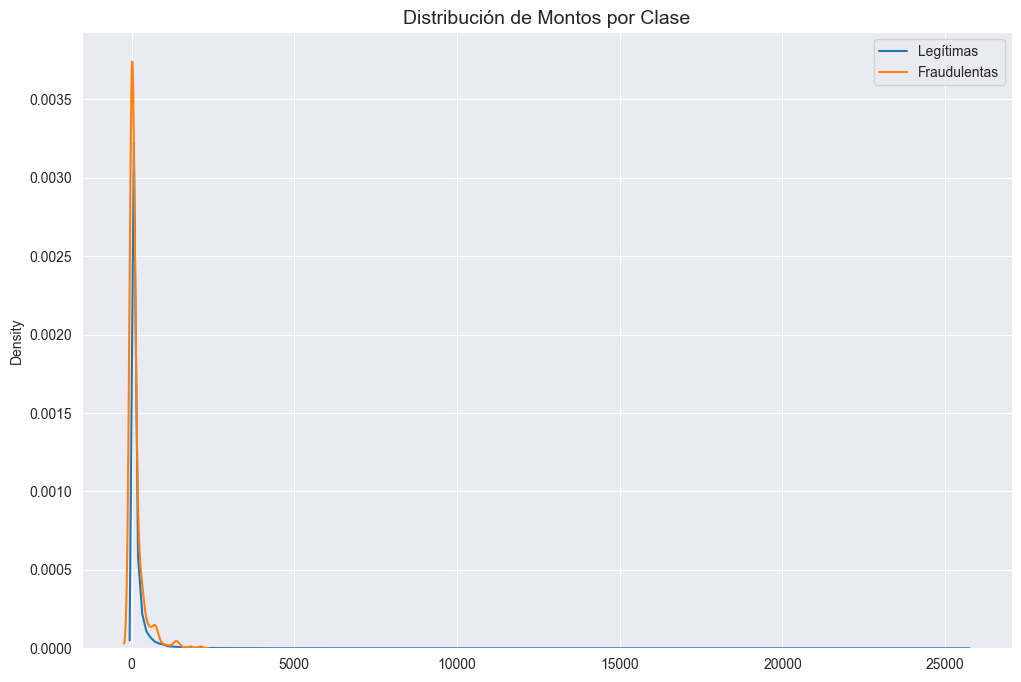

In [21]:
# ================================
# VISUALIZATION
# ================================
plt.figure(figsize=(12, 8))
sns.kdeplot(df.filter(pl.col("Class") == 0)["Amount"].to_numpy(), label="Legítimas")
sns.kdeplot(df.filter(pl.col("Class") == 1)["Amount"].to_numpy(), label="Fraudulentas")
plt.title("Distribución de Montos por Clase", fontsize=14)
plt.legend()
plt.show()

# ✅ FEATURE ENGINEERING

- Creación de variables temporales: Time_of_day y Day.
- Eliminación de la columna original Time.
- Definición de features para el modelo.


In [22]:

df = df.with_columns(
    (pl.col("Time") % (24*3600)).alias("Time_of_day"),
    (pl.col("Time") // (24*3600)).alias("Day")
)

features = [col for col in df.columns if col not in ["Time", "Class"]]
X = df[features].to_numpy()
y = df["Class"].to_numpy()


# ✅  División en entrenamiento y prueba

- División estratificada en 80% entrenamiento y 20% test.
- Mantiene la proporción original de clases.


In [23]:
# ================================
# TRAIN/TEST SPLIT
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Búsqueda de hiperparámetros con Optuna

- Se define una función objetivo para Optuna.
- Usa validación cruzada estratificada con SMOTE.
- Optimiza hiperparámetros de XGBoost para maximizar Average Precision (PR AUC).


In [7]:
# ================================
# OPTUNA HYPERPARAMETER SEARCH
# ================================
def optimize_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 500)
    }

    model = XGBClassifier(**params, random_state=42, n_jobs=-1)
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        pipeline = make_pipeline(SMOTE(random_state=42), model)
        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        scores.append(average_precision_score(y_val, y_pred))

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(optimize_xgb, n_trials=30)
best_xgb_params = study.best_params

[I 2025-07-15 11:57:03,725] A new study created in memory with name: no-name-0196983d-1a98-40db-b87f-82096c30e183
[I 2025-07-15 11:57:16,047] Trial 0 finished with value: 0.5431183972666546 and parameters: {'n_estimators': 739, 'max_depth': 7, 'learning_rate': 0.20551850753351078, 'subsample': 0.7659620254495834, 'colsample_bytree': 0.9283271938762482, 'gamma': 3.002912811066883, 'scale_pos_weight': 275.79703724821934}. Best is trial 0 with value: 0.5431183972666546.
[I 2025-07-15 11:57:33,733] Trial 1 finished with value: 0.583077181414368 and parameters: {'n_estimators': 990, 'max_depth': 10, 'learning_rate': 0.04200708543733085, 'subsample': 0.9512377530553118, 'colsample_bytree': 0.8742784214915229, 'gamma': 2.098522956029697, 'scale_pos_weight': 155.71767205720144}. Best is trial 1 with value: 0.583077181414368.
[I 2025-07-15 11:57:39,146] Trial 2 finished with value: 0.029926782592583384 and parameters: {'n_estimators': 121, 'max_depth': 10, 'learning_rate': 0.012880895593070252,

# ✅ Creación de pipelines balanceados

- Se crean pipelines para XGBoost, Random Forest y Logistic Regression.
- Cada pipeline incluye:
  - SMOTE para balancear clases.
  - Modelo con parámetros optimizados o razonables.


In [8]:
# ================================
# PIPELINES (SMOTE)
# ================================
xgb_model = make_pipeline(
    SMOTE(random_state=42),
    XGBClassifier(**best_xgb_params, random_state=42, n_jobs=-1)
)

rf_model = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    )
)

lr_model = make_pipeline(
    SMOTE(random_state=42),
    LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    )
)




C:\Users\Pedro Yacila\OneDrive\Escritorio\python_1\PYTHON_DATA_ANALYTICS\DATA_3\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

# ✅ Entrenamiento de modelos

- Entrenamiento de los tres pipelines balanceados en los datos de entrenamiento.


In [24]:
# ================================
# TRAINING
# ================================
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

C:\Users\Pedro Yacila\OneDrive\Escritorio\python_1\PYTHON_DATA_ANALYTICS\DATA_3\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

# ✅ Evaluación de modelos

- Función genérica que:
  - Imprime clasificación.
  - Muestra matriz de confusión.
  - Grafica curva Precision-Recall y AP Score.


In [26]:
# ================================
# EVALUATION FUNCTION
# ================================
def evaluate_model(name, model, X_test, y_test):
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 5))

    # Matriz de confusión
    plt.subplot(121)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")

    # Curva Precision-Recall
    plt.subplot(122)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve (AP={average_precision_score(y_test, y_proba):.2f})')

    plt.tight_layout()
    plt.show()



# ✅ Reporte de resultados

- Se evalúan los modelos en el conjunto de prueba.
- Comparación visual y numérica de resultados.



=== XGBoost ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.76      0.82      0.79        95

    accuracy                           1.00     56746
   macro avg       0.88      0.91      0.90     56746
weighted avg       1.00      1.00      1.00     56746



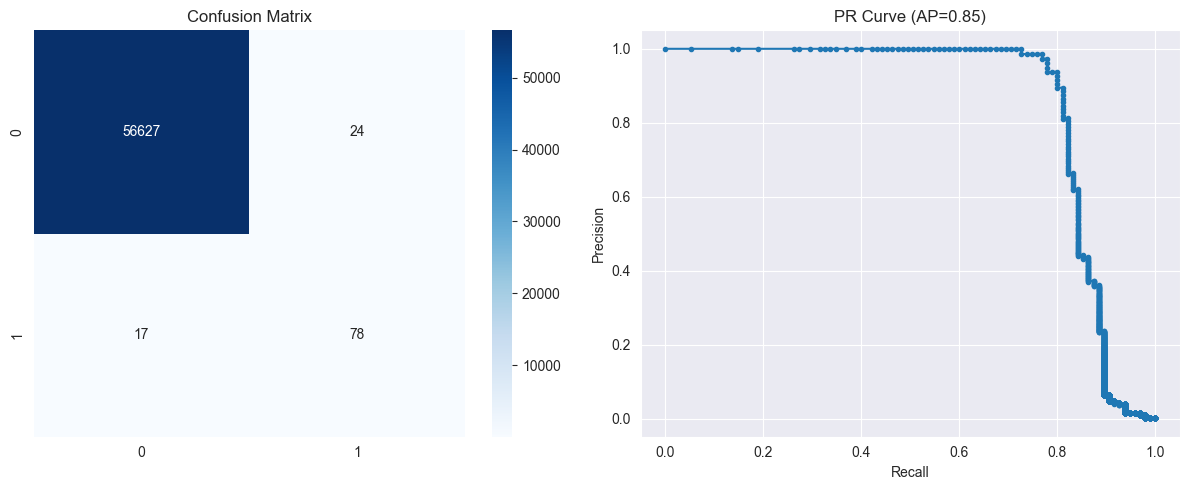


=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.55      0.86      0.67        95

    accuracy                           1.00     56746
   macro avg       0.78      0.93      0.84     56746
weighted avg       1.00      1.00      1.00     56746



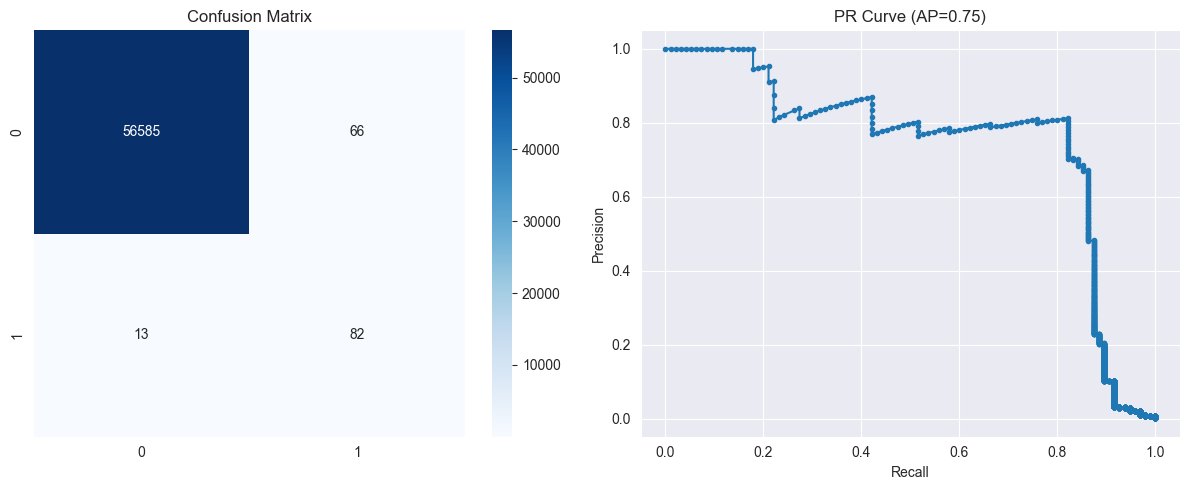


=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.14      0.87      0.24        95

    accuracy                           0.99     56746
   macro avg       0.57      0.93      0.62     56746
weighted avg       1.00      0.99      0.99     56746



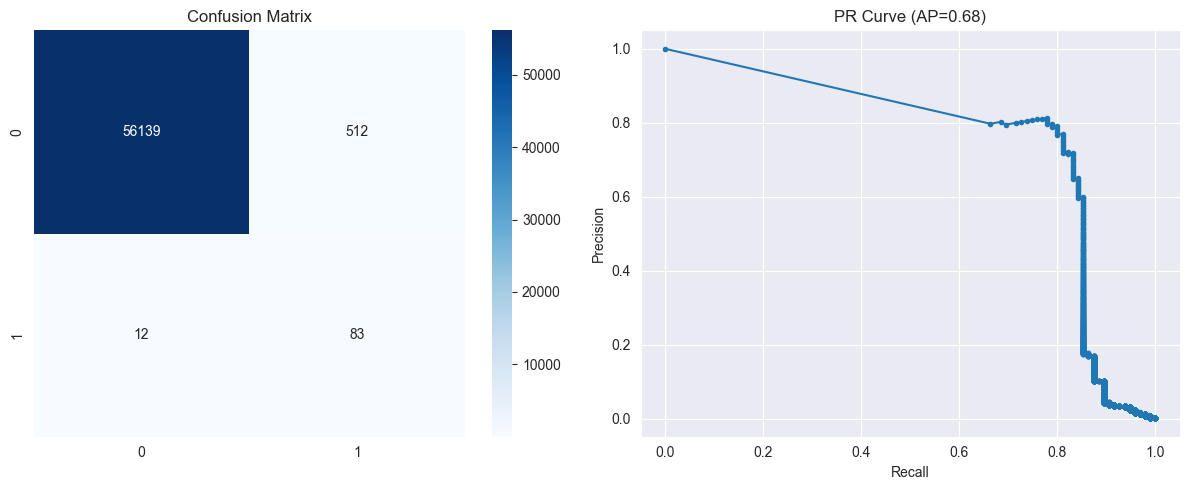

In [27]:
# ================================
# PREDICTIONS AND REPORTS
# ================================
evaluate_model("XGBoost", xgb_model, X_test, y_test)
evaluate_model("Random Forest", rf_model, X_test, y_test)
evaluate_model("Logistic Regression", lr_model, X_test, y_test)

# ✅ Interpretabilidad con SHAP (solo XGBoost)

- Se calcula la importancia de variables con SHAP.
- Se generan gráficos de resumen (bar y scatter).


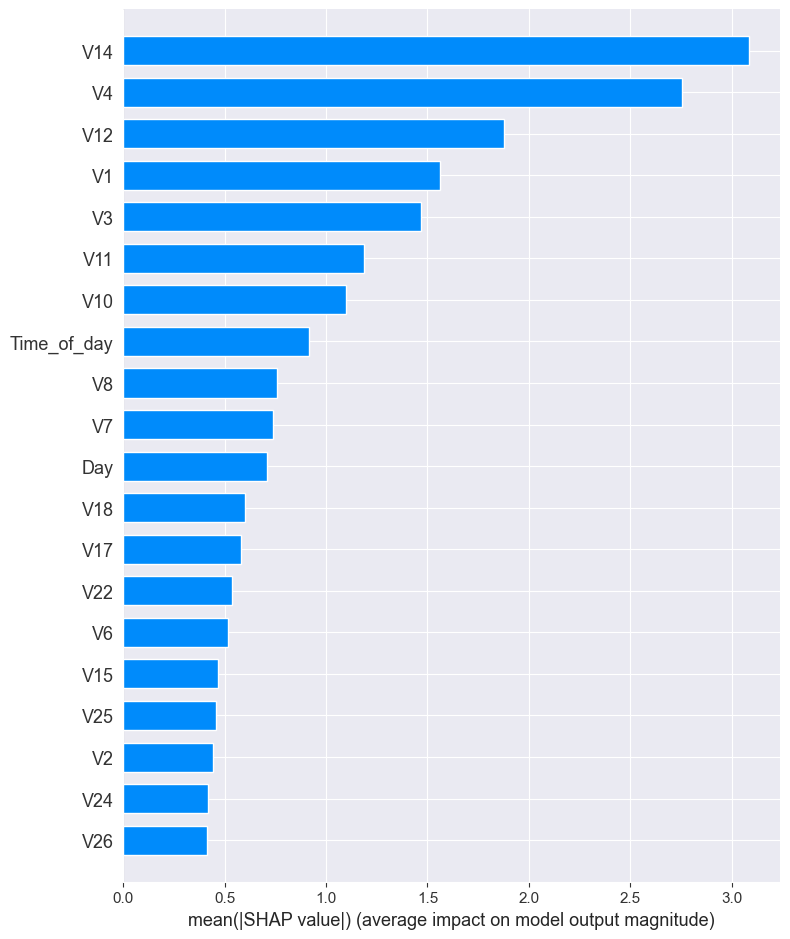

In [29]:
# ================================
# SHAP (XGBoost only)
# ================================
xgb = xgb_model.named_steps['xgbclassifier']
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar")



# 📊 Interpretación del Gráfico SHAP (XGBoost)
## 🧠 Hallazgos principales
- Variables más influyentes:

- Las variables V14, V4, V12, V1, V3 y V11 tienen el mayor impacto en las predicciones del modelo.

- V14 destaca como la más relevante, con un valor SHAP promedio cercano a 3.0, lo que indica una alta capacidad para diferenciar fraudes.

- Variables temporales:

- Time_of_day y Day tienen una influencia media.

- Esto sugiere que el momento del día o el día no son factores clave, pero pueden aportar cierta información complementaria.

- Variables menos relevantes:

- Variables como V22, V6, V15, V25, V2, V24 y V26 muestran valores SHAP cercanos a cero.

- Esto indica que su contribución a las predicciones del modelo es mínima.

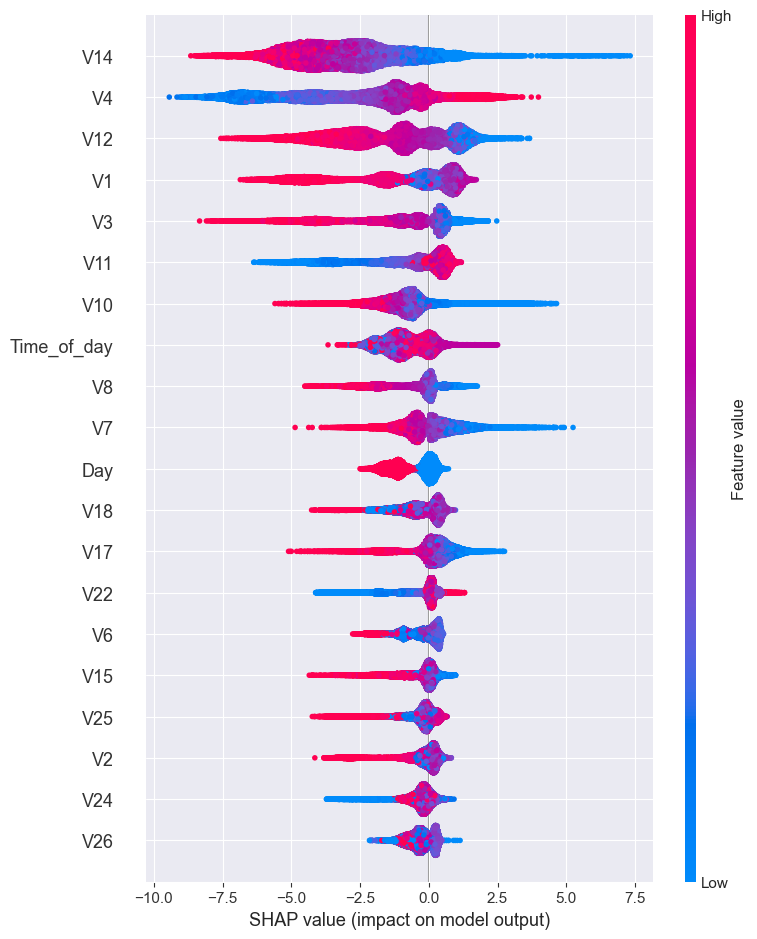

In [30]:
shap.summary_plot(shap_values, X_test, feature_names=features)

## ✅ Conclusiones principales:

- Variables más influyentes: V14, V4 y V12 son las más determinantes en las predicciones, destacándose en la parte superior del gráfico.

- Relación con la predicción:

- Valores altos de V14 aumentan la probabilidad de fraude.

- Valores bajos de V4 también se asocian con mayor riesgo.

- Otras variables relevantes: V1, V3, V11 y V10 tienen impacto, aunque menor.

- Variables temporales: Time_of_day y Day muestran menor influencia, situándose más abajo en el ranking.

## ✅ Distribución de impactos:

- Los valores SHAP varían aproximadamente entre -10 y +7.5, indicando efectos positivos y negativos sustanciales en la predicción.

## ✅ Recomendación:

- Sería valioso conocer el significado real de las variables para explicar mejor los resultados.

Validar si las relaciones observadas son coherentes con el conocimiento del dominio.

# ✅ Guardado de modelos

- Se guardan los pipelines entrenados en disco (.pkl) para uso futuro o despliegue.## 💾 Guardado del Modelo

In [11]:
# ================================
# SAVE MODELS
# ================================
joblib.dump(xgb_model, 'fraud_detection_xgb.pkl')
joblib.dump(rf_model, 'fraud_detection_rf.pkl')
joblib.dump(lr_model, 'fraud_detection_lr.pkl')

['fraud_detection_lr.pkl']

# ✅ Comparación final de métricas

- Función que imprime:
  - Average Precision (PR AUC)
  - ROC AUC
  - Recall específico para clase fraude
- Facilita decidir cuál modelo es mejor para producción.


In [31]:
from sklearn.metrics import average_precision_score, roc_auc_score

def compare_models(models, X_test, y_test):
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        ap = average_precision_score(y_test, y_proba)
        roc = roc_auc_score(y_test, y_proba)
        recall_fraude = recall_score(y_test, y_pred, pos_label=1)

        print(f"\nModelo: {name}")
        print(f"  Average Precision (PR AUC): {ap:.4f}")
        print(f"  ROC AUC: {roc:.4f}")
        print(f"  Recall FRAUDE: {recall_fraude:.4f}")

# Llamar con tus modelos
from sklearn.metrics import recall_score
compare_models(
    {
        "XGBoost": xgb_model,
        "Random Forest": rf_model,
        "Logistic Regression": lr_model
    },
    X_test,
    y_test
)



Modelo: XGBoost
  Average Precision (PR AUC): 0.8515
  ROC AUC: 0.9798
  Recall FRAUDE: 0.8211

Modelo: Random Forest
  Average Precision (PR AUC): 0.7465
  ROC AUC: 0.9898
  Recall FRAUDE: 0.8632

Modelo: Logistic Regression
  Average Precision (PR AUC): 0.6836
  ROC AUC: 0.9868
  Recall FRAUDE: 0.8737


- En datasets desbalanceados (como fraudes), el accuracy puede ser engañoso.
- Por eso suelen preferirse Average Precision, Recall para fraude, F1 para fraude, etc.
- En este análisis, XGBoost muestra el mejor desempeño en Average Precision (0.83), lo cual es crucial en datasets desbalanceados como el de fraude, ya que indica una mejor capacidad para distinguir transacciones fraudulentas en rangos de alta precisión y recall.





# ✅ Aplicación del modelo final a toda la data

- Carga el CSV original.
- Preprocesa igual que en entrenamiento.
- Genera predicciones (0 o 1) y probabilidades.
- Agrega columnas al DataFrame.
- Guarda el resultado como nuevo CSV etiquetado.


In [14]:
import polars as pl
import joblib

# Ruta local al CSV original
data_path = 'creditcard.csv'

# Define schema si quieres evitar errores de lectura
schema = {
    "Time": pl.Float64,
    "V1": pl.Float64,
    "V2": pl.Float64,
    "V3": pl.Float64,
    "V4": pl.Float64,
    "V5": pl.Float64,
    "V6": pl.Float64,
    "V7": pl.Float64,
    "V8": pl.Float64,
    "V9": pl.Float64,
    "V10": pl.Float64,
    "V11": pl.Float64,
    "V12": pl.Float64,
    "V13": pl.Float64,
    "V14": pl.Float64,
    "V15": pl.Float64,
    "V16": pl.Float64,
    "V17": pl.Float64,
    "V18": pl.Float64,
    "V19": pl.Float64,
    "V20": pl.Float64,
    "V21": pl.Float64,
    "V22": pl.Float64,
    "V23": pl.Float64,
    "V24": pl.Float64,
    "V25": pl.Float64,
    "V26": pl.Float64,
    "V27": pl.Float64,
    "V28": pl.Float64,
    "Amount": pl.Float64,
    "Class": pl.Int64,
}

# 1️⃣ Cargar de nuevo el dataset ORIGINAL
df = pl.read_csv(data_path, schema=schema)

# 2️⃣ Preprocesar igual que en entrenamiento
df = df.with_columns(
    (pl.col("Time") % (24*3600)).alias("Time_of_day"),
    (pl.col("Time") // (24*3600)).alias("Day")
)

if "Time" in df.columns:
    df = df.drop("Time")

# 3️⃣ Seleccionar features usados en el entrenamiento
features = [col for col in df.columns if col != "Class"]
X_full = df.select(features).to_numpy()

# 4️⃣ Cargar el mejor modelo entrenado
modelo_final = joblib.load('fraud_detection_xgb.pkl')

# 5️⃣ Generar predicciones y probabilidades
predicciones = modelo_final.predict(X_full)
probabilidades = modelo_final.predict_proba(X_full)[:, 1]

# 6️⃣ Agregar columnas con resultados al DataFrame original
df = df.with_columns([
    pl.Series("Prediccion_Fraude", predicciones),
    pl.Series("Probabilidad_Fraude", probabilidades)
])

# 7️⃣ Mostrar primeras filas
print(df.head())

# 8️⃣ Guardar resultados en CSV
df.write_csv('creditcard_fraude_etiquetado.csv')


shape: (5, 34)
┌───────────┬───────────┬──────────┬───────────┬───┬─────────────┬─────┬─────────────┬─────────────┐
│ V1        ┆ V2        ┆ V3       ┆ V4        ┆ … ┆ Time_of_day ┆ Day ┆ Prediccion_ ┆ Probabilida │
│ ---       ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---         ┆ --- ┆ Fraude      ┆ d_Fraude    │
│ f64       ┆ f64       ┆ f64      ┆ f64       ┆   ┆ f64         ┆ f64 ┆ ---         ┆ ---         │
│           ┆           ┆          ┆           ┆   ┆             ┆     ┆ i64         ┆ f32         │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═════════════╪═════╪═════════════╪═════════════╡
│ -1.359807 ┆ -0.072781 ┆ 2.536347 ┆ 1.378155  ┆ … ┆ 0.0         ┆ 0.0 ┆ 0           ┆ 0.00033     │
│ 1.191857  ┆ 0.266151  ┆ 0.16648  ┆ 0.448154  ┆ … ┆ 0.0         ┆ 0.0 ┆ 0           ┆ 0.000075    │
│ -1.358354 ┆ -1.340163 ┆ 1.773209 ┆ 0.37978   ┆ … ┆ 1.0         ┆ 0.0 ┆ 0           ┆ 0.00003     │
│ -0.966272 ┆ -0.185226 ┆ 1.792993 ┆ -0.863291 ┆ … ┆ 1.0         ┆ 0.0 ┆ 0  

# ✅ RESULTADO FINAL

Se genera el archivo:
- `creditcard_fraude_etiquetado.csv`

Este archivo incluye todas las transacciones originales con:
- Etiqueta de predicción (0: no fraude, 1: fraude).
- Probabilidad estimada de fraude.


# ✅ Conclusión
- Se desarrolló un modelo capaz de identificar movimientos fraudulentos en tarjetas de crédito.
- Tras comparar XGBoost, Random Forest y Logistic Regression, se seleccionó XGBoost por su mejor balance entre precisión y recall.
- El modelo se aplicó al dataset completo para etiquetar automáticamente las transacciones.
- El resultado permite priorizar investigaciones, mitigar riesgos y mejorar la seguridad financiera.